# Met Eireann wind speed analysis
## Programming for Data Analytics Project
Author: Vanessa de Oliveira Lyra


Met Éireann weather stations close to Wind Farms in Ireland with wind speed data available:  
- Mace Head (Galway)  
- Malin Head (Donegal)  
- Ireland West Knock Airport (Mayo)  
- Ballyhaise (Cavan)  
- Gurteen (Tipperary)  
- Mount Dillon (Roscommon)   

References:  
Weather stations and wind data: https://www.met.ie/climate/available-data/historical-data  
Weather stations proximity to Windfarms: https://chatgpt.com/share/695583bd-1238-8006-ac31-fcac77086ace

### Importing libraries

In [481]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sb
import numpy as np
from windrose import WindroseAxes
import matplotlib.ticker as mtick

### Database connection and data fetching

In [482]:
# Connecting to SQLite and creating database file
conn = sqlite3.connect("windspeed.db")

Daily data files

In [483]:
# Mapping CSV filepaths
weather_files = {
    "mace": "datasets/dly275_mace_head.csv",
    "malin": "datasets/dly1575_malin_head.csv",
    "knock": "datasets/dly4935_knock_airport.csv",
    "ballyhaise": "datasets/dly675_ballyhaise.csv",
    "gurteen": "datasets/dly1475_gurteen.csv",
    "mtdillon": "datasets/dly1975_mt_dillon.csv"}

# Dictionaries to store data
df_weather = {}

# For loop to read CSV files
for key, value in weather_files.items():
    df_weather[key] = pd.read_csv(value, skiprows=24) 

Hourly data files

In [484]:
# Mapping CSV filepaths
weather_hly_files = {
    "mace_hly": "datasets/hly275_mace_head.csv",
    "malin_hly": "datasets/hly1575_malin_head.csv",
    "knock_hly": "datasets/hly4935_knock_airport.csv",
    "ballyhaise_hly": "datasets/hly675_ballyhaise.csv",
    "gurteen_hly": "datasets/hly1475_gurteen.csv",
    "mtdillon_hly": "datasets/hly1975_mt_dillon.csv"}

# Dictionaries to store data
df_weather_hly = {}

# For loop to read CSV files
# Stations with header on line 18
for key in ["mace_hly", "ballyhaise_hly", "gurteen_hly", "mtdillon_hly"]:
    df_weather_hly[key] = pd.read_csv(weather_hly_files[key], skiprows=17,low_memory=False)

# Stations with header on line 24
for key in ["malin_hly", "knock_hly"]:
    df_weather_hly[key] = pd.read_csv(weather_hly_files[key], skiprows=23,low_memory=False)

In [485]:
# Printing head for reference
# print(df_mace.head())

# Print headers for reference
#headers = df.columns.tolist()
# headers

##### References:
Skiprows function: https://stackoverflow.com/questions/20637439/skip-rows-during-csv-import-pandas   
Writing data to SQlite: https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index  
Importing multiple files: https://stackoverflow.com/questions/56155629/reading-multiple-csv-files-with-different-names-using-python-dictionary-in-a-for  
Low_memory from error: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False

### Cleaning up dataset data

Daily data files

In [486]:
# List of columns from dataset to be dropped
drop_columns = ["ind","maxtp","ind.1","mintp","igmin","gmin","ind.2","cbl","ind.3","ind.4","ind.5","sun","dos","soil","pe","evap","smd_wd","smd_md","smd_pd","glorad"]

# Loop over all stations
for weather_files, df in df_weather.items():
    # Drop unwanted columns
    df.drop(columns=drop_columns, inplace=True, errors="ignore")
    
    # Normalizing date column
    # Removing white spaces from data using stip()
    # Converting data to datetime, coerce will replace any invalid dates with NaT
    df["date"] = df["date"].astype(str).str.strip()
    df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y", errors="coerce")
    
    # Convert dataset columns to numeric values using for loop
    for col in ["wdsp", "hm", "hg", "ddhm","rain"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Update the dictionary with the cleaned DataFrame
    df_weather[weather_files] = df
    
    # Writing clean data to database
    df.to_sql(f"{weather_files}_data", conn, if_exists="replace", index=False)

# Example: print Mace head after cleaning
print(df_weather["mace"].head())

        date  rain  wdsp    hm   ddhm    hg
0 2003-08-14   0.0   6.7  13.0   60.0  17.0
1 2003-08-15   0.0   6.5  12.0  280.0  15.0
2 2003-08-16   0.0   5.7  10.0  200.0  13.0
3 2003-08-17   3.3  16.9  26.0  180.0  34.0
4 2003-08-18   0.2  18.5  23.0  270.0  28.0


Hourly data files

In [487]:
# Hourly files
# List of columns from dataset to be dropped
drop_columns = ["ind","ind.2","ind.3","wetb","dewpt","vappr","rhum","msl","ind.5","ind.6","ww","w","sun","vis","clht","clamt"]

# Loop over all stations
for weather_hly_files, df in df_weather_hly.items():
    # Drop unwanted columns
    df.drop(columns=drop_columns, inplace=True, errors="ignore")
    
    # Normalizing date column
    # Removing white spaces from data using stip()
    # Converting data to datetime, coerce will replace any invalid dates with NaT
    df["date"] = df["date"].astype(str).str.strip()
    df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y %H:%M", errors="coerce")
    
    # Convert dataset columns to numeric values using for loop
    for col in ["wdsp", "temp", "wddir","rain"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Update the dictionary with the cleaned DataFrame
    df_weather_hly[weather_hly_files] = df
    
    # Writing clean data to database
    df.to_sql(f"{weather_hly_files}_data", conn, if_exists="replace", index=False)

# Example: print Mace head after cleaning
print(df_weather_hly["mace_hly"].head())


                 date  rain  ind.1  temp  wdsp  ind.4  wddir
0 2003-08-13 01:00:00   NaN      4   NaN   NaN      7    NaN
1 2003-08-13 02:00:00   NaN      4   NaN   NaN      7    NaN
2 2003-08-13 03:00:00   NaN      4   NaN   NaN      7    NaN
3 2003-08-13 04:00:00   NaN      4   NaN   NaN      7    NaN
4 2003-08-13 05:00:00   NaN      4   NaN   NaN      7    NaN


##### References
Remove whitespaces from date: https://medium.com/@amit25173/how-to-remove-whitespace-from-strings-in-pandas-bfd9acdc55f3  
Converting datetime: https://pbpython.com/pandas_dtypes.html  
Convert data to numeric values https://kajodata.com/en/knowledge-base-excel-sql-python/knowledge-base-python-tech-skillshow-pandas-to_numeric-works-in-python-examples-mmk/  
Dates showing as NaT after claening data updated date format from %d-%b-%y to %d-%b-%Y to handle 4-digits year: https://medium.com/@codecorecomputercenter/python-date-formats-a-comprehensive-guide-c6ed0224980b     
For loop convert columns to numeric: https://stackoverflow.com/questions/50456153/use-to-numeric-on-certain-columns-only-in-pandas  

Station names and labels

In [488]:
# List of stations to be analysed
all_stations = ["mace", "malin", "knock", "ballyhaise", "gurteen","mtdillon"]
all_stations_hly = ["mace_hly", "ballyhaise_hly", "gurteen_hly", "mtdillon_hly","malin_hly", "knock_hly"]
labels = ["Mace Head", "Malin Head", "Ireland West Knock Airport", "Ballyhaise", "Gurteen", "Mount Dillon"]

### Wind Power calculation

Formula: Power (W) = 1/2 x ρ x A x v3  
ρ = density of the air 1.225 kg/m3  
A = cross-sectional area of the wind in m2  
v = velocity of the wind in m/s 

In [489]:
# Converting wind speed and calculating wind power, daily data
for key in all_stations:
    df = df_weather[key]
    # Converting windspeed in knots to m/s
    df["ms_wdsp"] = df["wdsp"] * 0.51444
    
    # Calculating wind power to all stations, 
    df["wind_power"] = (0.5 * 1.255 * (df["ms_wdsp"] ** 3))

    # Saving data to SQL, getting file name, if table already exists is will be replaced
    df.to_sql(f"{key}_data",conn, if_exists="replace", index = False)

In [490]:
# Converting wind speed and calculating wind power, hourly data
for key in all_stations_hly:
    df = df_weather_hly[key]
    # Converting windspeed in knots to m/s
    df["ms_wdsp"] = df["wdsp"] * 0.51444
    
    # Calculating wind power to all stations
    df["wind_power"] = (0.5 * 1.255 * (df["ms_wdsp"] ** 3))

    # Saving data to SQL, getting file name, if table already exists is will be replaced
    df.to_sql(f"{key}_data",conn, if_exists="replace", index = False)

##### References: 
Convert windspeed to m/s: https://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-pythonhttps://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-python  
Wind power calculation:https://www.e-education.psu.edu/emsc297/node/649#:~:text=The%20power%20in%20the%20wind%20at%206%20m/s%20is,MW%20(27%20times%20as%20large)   


### Wind Speed Statistics (per location)

In [491]:
# Dictionary to store stats
all_stats = {}

# Loop through stations, retrieving statistics using only relevant .describe() results
for key in all_stations:
    all_stats[key] = df_weather[key][["ms_wdsp"]].describe().loc[["mean", "std", "min", "max"]]

# Concatenating data side by side (axis=1) for better visualization, keys are column/station names
windspeed_stats = pd.concat(all_stats.values(), axis=1, keys=all_stats.keys())

# Removing unecessary header wdsp
windspeed_stats.columns = windspeed_stats.columns.droplevel(1)

# Round numbers, show one decimal
windspeed_stats = windspeed_stats.round(1)

# Printing result
print("Wind Speed Stats:\n")
print(windspeed_stats)

Wind Speed Stats:

      mace  malin  knock  ballyhaise  gurteen  mtdillon
mean   7.4    7.8    4.9         3.3      4.2       3.6
std    3.3    3.3    2.0         1.5      1.9       1.6
min    0.1    0.1    0.0         0.1      0.1       0.1
max   21.3   23.0   13.8        10.3     12.5      49.8


##### References

Filtering df.describe(): https://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe  
Concatenating statistics: https://pandas.pydata.org/docs/user_guide/merging.html  
Removing extra column "wdsp" from final table: https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index  
Rounding column values: https://stackoverflow.com/questions/26133538/round-a-single-column-in-pandas

### Hourly windspeed patterns (in m/s)

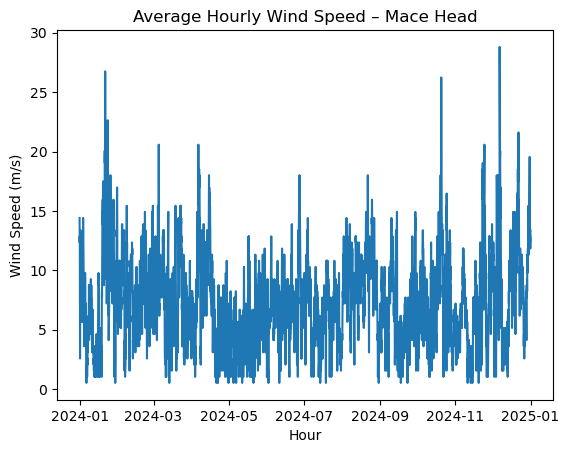

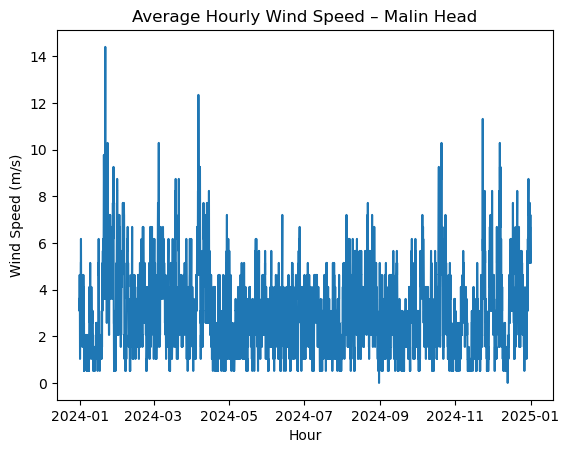

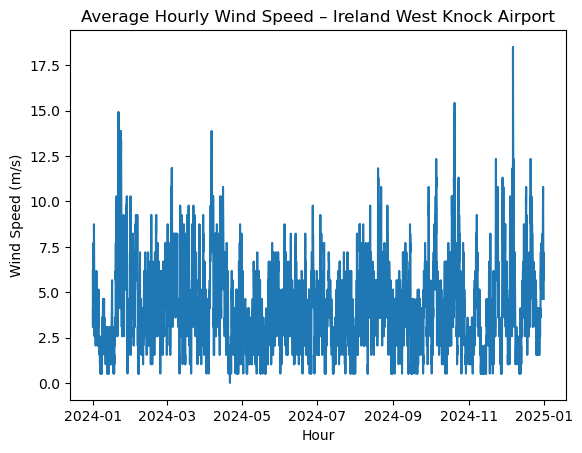

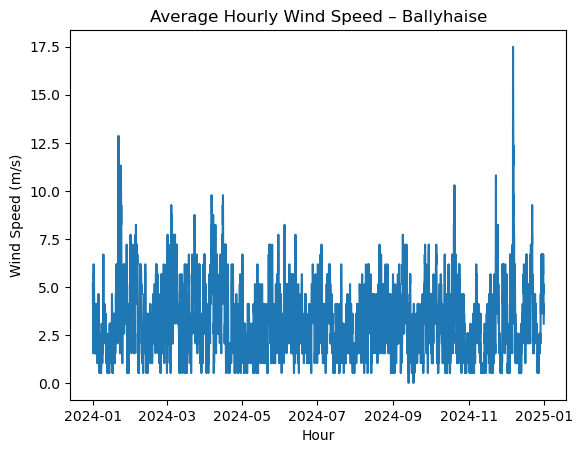

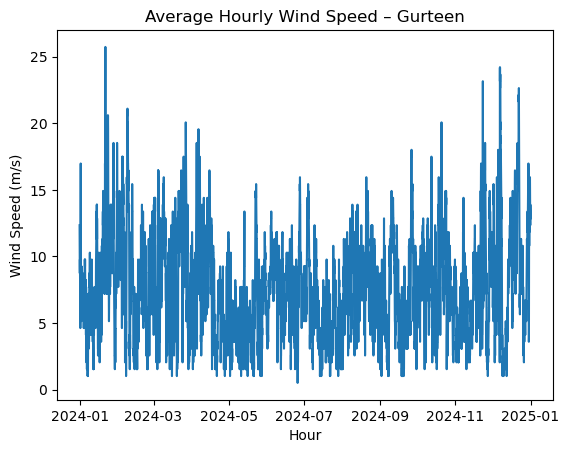

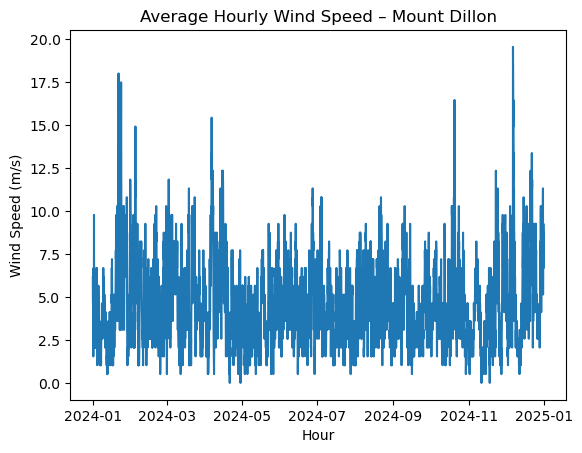

In [492]:
# Loop through stations
for i in range(len(all_stations_hly)): #Loop throught the length of the data, number of times to loop through
    station = all_stations_hly[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
     # Filtering data from year 2000 and on
    df_2024 = df_weather_hly[station][df_weather_hly[station]["date"].dt.year == 2024]
    
    # Grouping data and windspeed and calculating mean yearly windspeed 
    hourly_mean = df_2024.groupby(df_2024["date"])["ms_wdsp"].mean()
    
    # Ploting lines
    plt.plot(hourly_mean, label=label)

    # Printstatement for testing
    # print(monthly_mean)

    # Adding legend, title, and axis labels
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
    plt.title(f"Average Hourly Wind Speed – {label}")
    plt.xlabel("Hour")
    plt.ylabel("Wind Speed (m/s)")

    plt.show()

### Monthly windspeed patterns (knots)

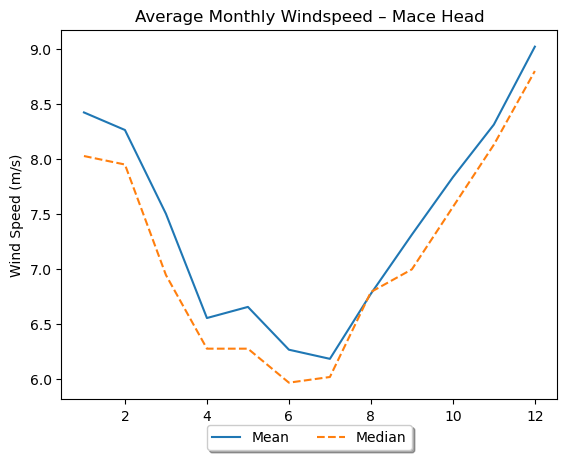

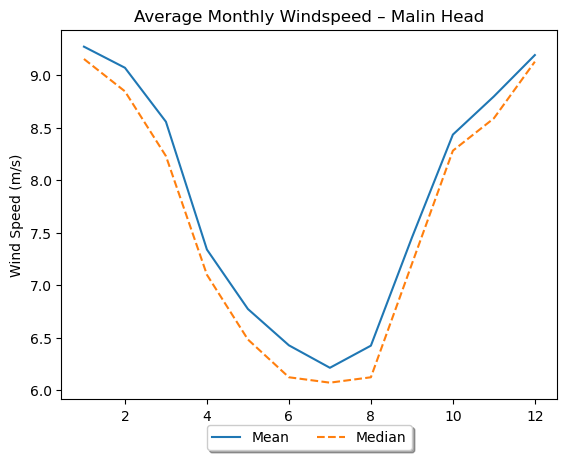

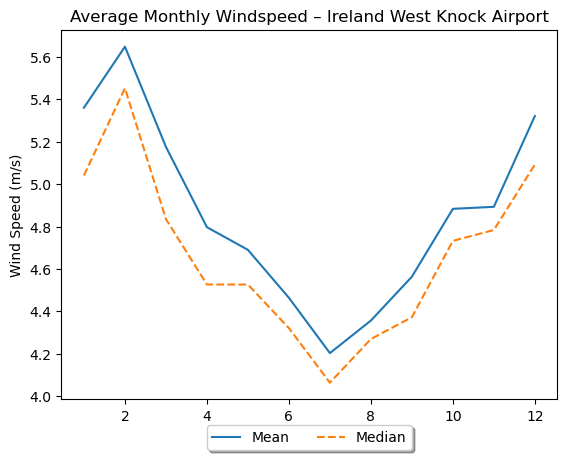

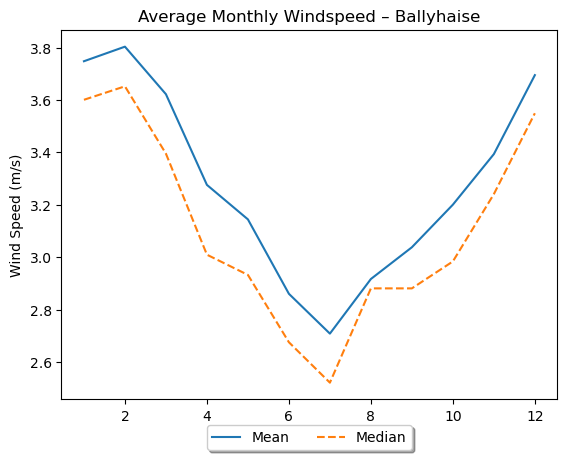

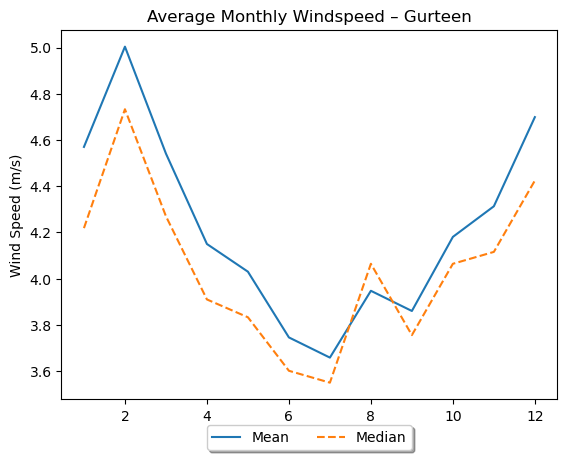

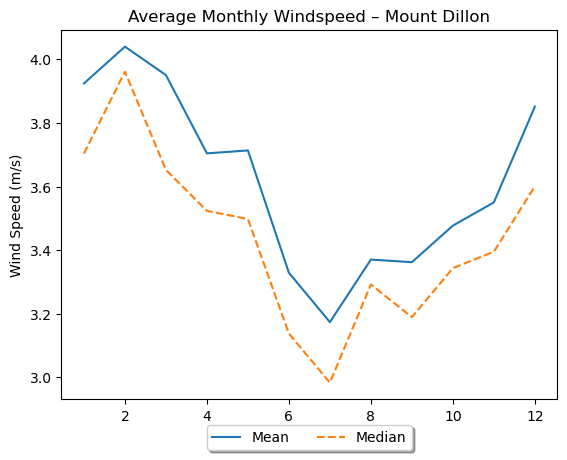

In [493]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    monthly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].mean()
    monthly_median = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].median()
    # Ploting lines
    plt.plot(monthly_mean, label="Mean")
    plt.plot(monthly_median, linestyle="--",label="Median")

    # Printstatement for testing
    # print(monthly_mean)

    # Adding legend, title, and axis labels
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
    plt.title(f"Average Monthly Windspeed – {label}")
    plt.xlabel("Month")
    plt.ylabel("Wind Speed (m/s)")
    plt.show()

##### References
Legend position: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

### Yearly windspeed patterns (knots)

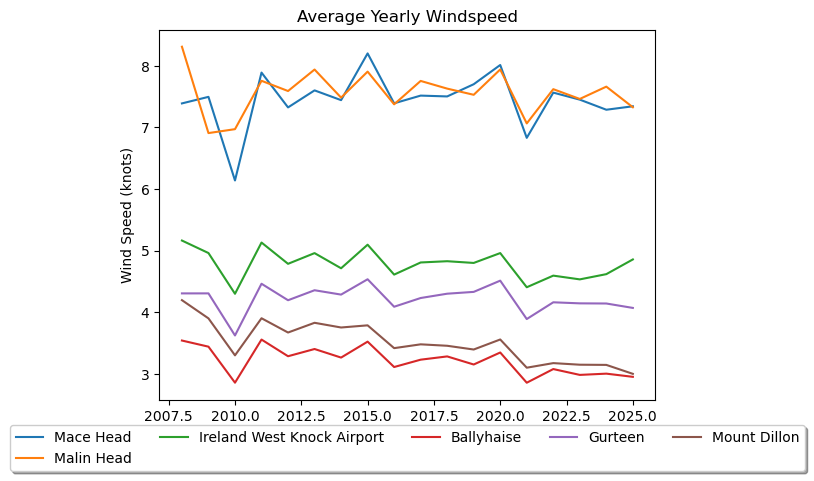

In [494]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Filtering data from year 2008 and on
    df_2008 = df_weather[station][df_weather[station]["date"].dt.year >= 2008]
    
    # Grouping data and windspeed and calculating mean yearly windspeed 
    yearly_mean = df_2008.groupby(df_2008["date"].dt.year)["ms_wdsp"].mean()

    # Ploting lines
    plt.plot(yearly_mean, label=label)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Average Yearly Windspeed")
plt.xlabel("Year")
plt.ylabel("Wind Speed (knots)")
plt.show()

### Wind power stations stats

In [495]:
# Dictionary to store wind power stats
wdpw_stats = {}

# Loop through stations, retrieving statistics using only relevant .describe() results
for key in all_stations:
    wdpw_stats[key] = df_weather[key][["wind_power"]].describe().loc[["mean", "std", "min", "max"]]

# Concatenating data side by side (axis=1) for better visualization, keys are column/station names
wdpw_stats_all = pd.concat(wdpw_stats.values(), axis=1, keys=wdpw_stats.keys())

# Removing unecessary header
wdpw_stats_all.columns = wdpw_stats_all.columns.droplevel(1)

# Round numbers, show one decimal
wdpw_stats_all = wdpw_stats_all.round(1)

# Printing result
print(wdpw_stats_all)

        mace   malin   knock  ballyhaise  gurteen  mtdillon
mean   426.1   476.6   111.6        37.1     77.0      57.9
std    586.2   608.8   148.3        52.8    106.4     883.2
min      0.0     0.0     0.0         0.0      0.0       0.0
max   6106.1  7681.6  1644.5       693.8   1225.8   77489.7


In [496]:
# Debugging line, checking if calculated widspeed and wind power are in the database
# pd.read_sql("PRAGMA table_info(mace_data);", conn)

### Station ranking by Wind Power

In [497]:
# Getting mean wind power from wdpw_stats_all
avg_wdpw = wdpw_stats_all.loc["mean"]

# Convert the Series to a DataFrame
df_wdpw = avg_wdpw.to_frame(name="Avg Wind Power")

# Sort stations from highest to lowest wind power
df_wdpw = df_wdpw.sort_values("Avg Wind Power", ascending=False)

# Round numbers and print
print("Stations Ranked by Average Wind Power:\n")
print(df_wdpw.round(2))

Stations Ranked by Average Wind Power:

            Avg Wind Power
malin                476.6
mace                 426.1
knock                111.6
gurteen               77.0
mtdillon              57.9
ballyhaise            37.1


##### References: 



Debugging line: https://stackoverflow.com/questions/66897013/sqlite-how-to-return-the-output-of-pragma-table-info-in-a-pandas-dataframe  
To_frame() function: https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe  
Sorting values: https://stackoverflow.com/questions/24988873/python-sort-descending-dataframe-with-pandas 

### Boxplots - Wind Power Distribution per Station

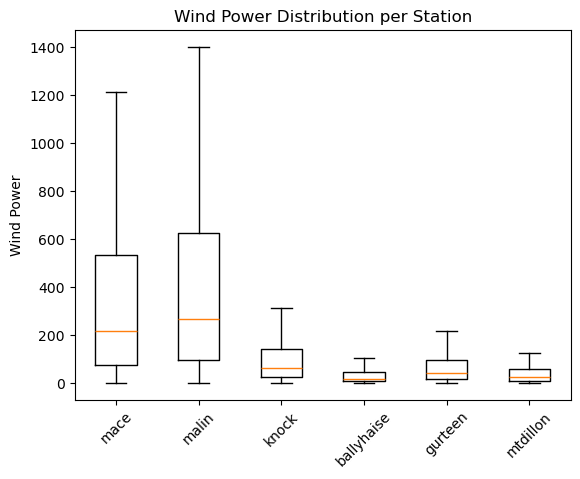

In [498]:
plt.boxplot([df_weather[key]["wind_power"].dropna() for key in all_stations],tick_labels=all_stations,showfliers=False)
plt.xticks(rotation=45)
plt.ylabel("Wind Power")
plt.title("Wind Power Distribution per Station")
plt.show()

##### References:
Boxplots from multiple dictionaries: https://stackoverflow.com/questions/64169288/box-plot-a-data-from-dictionaries-key-in-python  
Including N/A values: https://stackoverflow.com/questions/79767967/making-matplotlib-boxplot-include-columns-with-nan-values  
Remove outliers for data: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot  
Drop table: https://stackoverflow.com/questions/58951334/aiopg-sqlalchemy-how-to-drop-table-if-exists-without-raw-sql

### Operational wind speed for wind farms

Wind turbine limits:  
Cut-in: ~3 m/s  
Cut-out: ~25 m/s  
Rated: ~12 m/s  

In [499]:
# Creating a dictionary to store operation windspeed
operational_stats = {}

# Looping through weather station name from all_stations variable
for key in all_stations:
    # Retrieving DF for the station
    df = df_weather[key]
    
    # Filter operational windspeeds (in m/s) within cut-in and cut-out
    stats_limits = df[(df["ms_wdsp"] >= 3) & (df["ms_wdsp"] <= 25)]
    
    # Finding percentage  of operational windspeed
    # len(stats_limits): how amny times windspeed was within operational range
    # len(df): total number of windspeed records
    operational_perc = len(stats_limits) / len(df) * 100

    # Storing results in dictionary previously created
    operational_stats[key] = operational_perc

# Converting dictionary operational_stats to a Dataframe
# orient: dictionary keys (station names) will be the table rows
operational_perc = (pd.DataFrame.from_dict(operational_stats, orient="index", columns=["Operational wind (%)"]).round(1))

print(operational_perc)

            Operational wind (%)
mace                        93.5
malin                       94.7
knock                       82.0
ballyhaise                  50.8
gurteen                     71.0
mtdillon                    60.3


##### References: 

Wind turbine limits: https://www.nyserda.ny.gov/-/media/Project/Nyserda/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, pp.5  
pd.DataFrame.from_dict function: https://builtin.com/data-science/dictionary-to-dataframe#:~:text=pandas.-,DataFrame.,parsed%20as%20a%20DataFrame%20row.  

### Monthly wind power

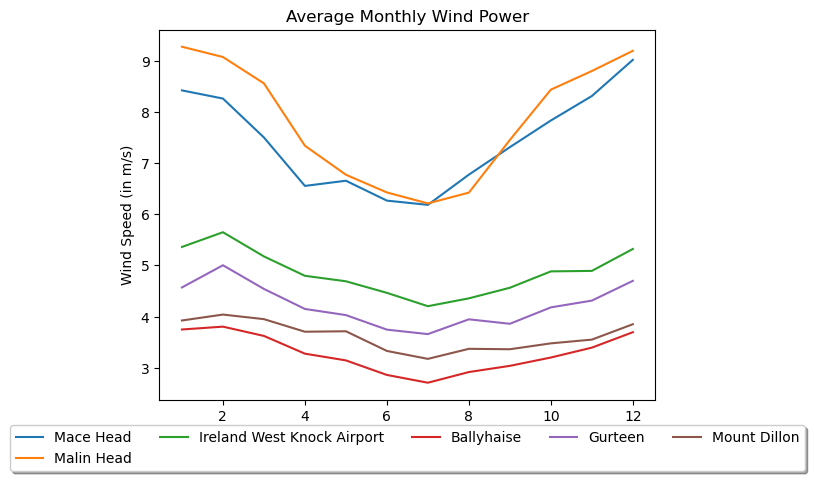

In [500]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    monthly_wdpw = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].mean()
    
    # Ploting lines
    plt.plot(monthly_wdpw, label=label)

    # Printstatement for testing
    # print(monthly_mean)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Average Monthly Wind Power")
plt.xlabel("Month")
plt.ylabel("Wind Speed (in m/s)")
plt.show()

In [501]:
# Debugging, see windspeed and wind power results
# pd.read_sql("SELECT ms_wdsp, wind_power FROM mace_data LIMIT 5;", conn)

### Windfarm downtime frequency

In [502]:
# Variable to store unoperational wind power
wind_percentage = []

# Loop through all stations data
for key in all_stations:
    table_name = f"{key}_data"

# Calculating percentage of unoperational windpower 
# Count when windspeed is < 3 or >= 25
    query = f""" 
    SELECT 
        COUNT(CASE WHEN ms_wdsp < 3 THEN 1 END) * 100.0 / COUNT(*) AS light_wind_perc,
        COUNT(CASE WHEN ms_wdsp >= 25 THEN 1 END) * 100.0 / COUNT(*) AS strong_wind_perc
    FROM {table_name}"""
    
    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result = pd.read_sql(query, conn).round(1)
    result["Station"] = key # Adding a new column with station names
    wind_percentage.append(result) # Appending each result to variable wind_percentage

# Concating data from all stations to one dataframe
unoperational_df = pd.concat(wind_percentage, ignore_index=True)
print(unoperational_df)    

   light_wind_perc  strong_wind_perc     Station
0              6.4               0.0        mace
1              5.3               0.0       malin
2             17.9               0.0       knock
3             49.0               0.0  ballyhaise
4             28.9               0.0     gurteen
5             39.6               0.0    mtdillon


##### References:

SQL count query: https://www.interviewquery.com/p/sql-count-case-when  
Fixing error "unterminated f-string literal": https://stackoverflow.com/questions/68025686/how-to-do-python-f-strings-in-triple-quotes  
Round statement: https://stackoverflow.com/questions/76649671/how-do-i-round-the-numbers-in-a-df-column-correctly-in-python  
Appending reults to DF and concat: https://stackoverflow.com/questions/18107953/how-to-create-a-large-pandas-dataframe-from-an-sql-query-without-running-out-of  

### Seasonal average wind power

In [503]:
# Variable to store wind power by season
season_wdpw = []

# Loop through stations from all_stations
for key in all_stations:
    # Getting table names to be looped through, station name + _data
    table_name = f"{key}_data"

    # Query to calculate wind power by season
    # Each season is divided by its corresponden month number, strftime gets the month portion of the date
    query1 = f"""
    SELECT 
        CASE 
            WHEN strftime("%m", date) IN ("12","01","02") THEN "Winter"
            WHEN strftime("%m", date) IN ("03","04","05") THEN "Spring"
            WHEN strftime("%m", date) IN ("06","07","08") THEN "Summer"
            ELSE "Autumn"
        END AS season,
        AVG(wind_power) AS avg_season
    FROM {table_name}
    GROUP BY 
        CASE 
            WHEN strftime("%m", date) IN ("12","01","02") THEN "Winter"
            WHEN strftime("%m", date) IN ("03","04","05") THEN "Spring"
            WHEN strftime("%m", date) IN ("06","07","08") THEN "Summer"
            ELSE "Autumn"
        END
    """

    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result1 = pd.read_sql(query1, conn).round(1)
    result1["Station"] = key # Adding a new column with station names
    season_wdpw.append(result1) # Appending each result to variable season_wdpw

# Concating data from all stations to one dataframe
season_df = pd.concat(season_wdpw, ignore_index=True)

# Pivoting data for visualization
season_pvt = season_df.pivot(
    index="Station",
    columns="season",
    values="avg_season")

# Turning station from index to a normal column
season_pvt = season_pvt.reset_index()
print(season_pvt)


season     Station  Autumn  Spring  Summer  Winter
0       ballyhaise    34.1    37.5    20.8    56.3
1          gurteen    70.5    77.2    48.9   113.4
2            knock   104.4   111.6    72.0   159.9
3             mace   466.8   335.6   257.1   649.9
4            malin   527.8   429.3   250.7   706.1
5         mtdillon    41.7    53.6    71.0    65.9


Hourly variation by season

In [504]:
# Variable to store wind power by season
hly_season_wdpw = []

# Loop through stations from all_stations
for key in all_stations_hly:
    # Getting table names to be looped through, station name + _data
    table_name = f"{key}_data"

    # Query to calculate wind power by season
    # Each season is divided by its corresponden month number, strftime gets the month portion of the date
    query4 = f"""
    SELECT
    CASE
        WHEN strftime('%m', date) IN ('12','01','02') THEN 'Winter'
        WHEN strftime('%m', date) IN ('03','04','05') THEN 'Spring'
        WHEN strftime('%m', date) IN ('06','07','08') THEN 'Summer'
        ELSE 'Autumn'
    END AS season_hly,
    strftime('%H', date) AS hour,
    AVG(wind_power) AS avg_season_hly
    FROM {table_name}
    GROUP BY season_hly, hour
    ORDER BY season_hly, hour;
    """

    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result4 = pd.read_sql(query4, conn).round(1)
    result4["Station"] = key # Adding a new column with station names
    hly_season_wdpw.append(result4) # Appending each result to variable season_wdpw

# Concating data from all stations to one dataframe
season_df_hly = pd.concat(hly_season_wdpw, ignore_index=True)

# Pivoting data for visualization
season_pvt_hly = season_df.pivot(
    index="Station",
    columns="season",
    values="avg_season")

# Turning station from index to a normal column
season_pvt = season_pvt.reset_index()
print(season_pvt)

season  index     Station  Autumn  Spring  Summer  Winter
0           0  ballyhaise    34.1    37.5    20.8    56.3
1           1     gurteen    70.5    77.2    48.9   113.4
2           2       knock   104.4   111.6    72.0   159.9
3           3        mace   466.8   335.6   257.1   649.9
4           4       malin   527.8   429.3   250.7   706.1
5           5    mtdillon    41.7    53.6    71.0    65.9


##### References:

Code inspiration SQL query: https://stackoverflow.com/questions/51250537/case-when-expression-for-dates-in-sql-query  
Code inspiration 2 SQL query:https://stackoverflow.com/questions/650480/get-month-from-datetime-in-sqlite  
Fixing error "no such column: season" Group by SQL : https://www.geeksforgeeks.org/sqlite/sqlite-group-by-clause/  
Pivot data: https://www.influxdata.com/blog/pandas-pivot-tutorial/#:~:text=index:%20The%20index%20parameter%20sets,Here's%20a%20detailed%20breakdown:
Reset index: https://www.dataquest.io/blog/tutorial-reset-index-in-pandas/  
Reset index: https://stackoverflow.com/questions/40914200/can-i-assign-a-reset-index-a-name

### Seasonal heatmap

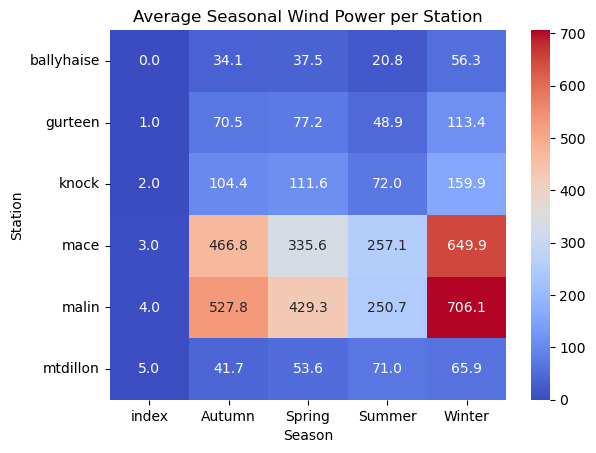

In [505]:
sb.heatmap(season_pvt.set_index("Station"), fmt=".1f", annot=True, cmap="coolwarm")
plt.title("Average Seasonal Wind Power per Station")
plt.ylabel("Station")
plt.xlabel("Season")
plt.show()

Heatmap: https://indianaiproduction.com/seaborn-heatmap/  
Remove long numbers from heatmap, one decimal place: https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format

### Station trends

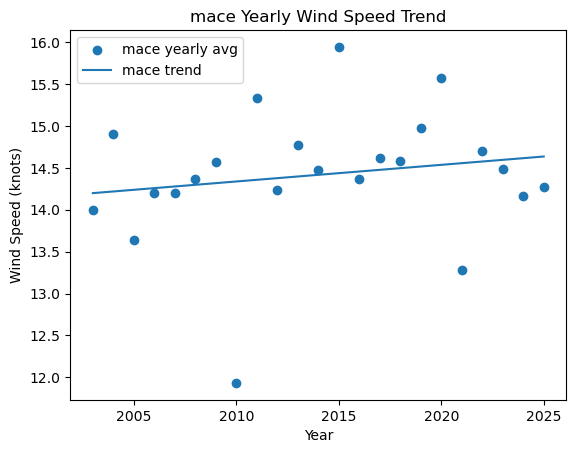

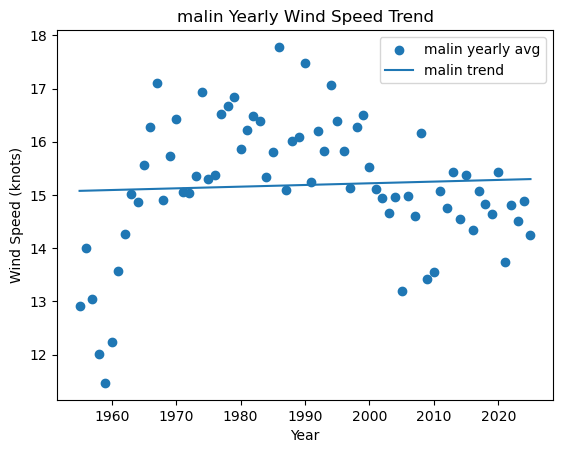

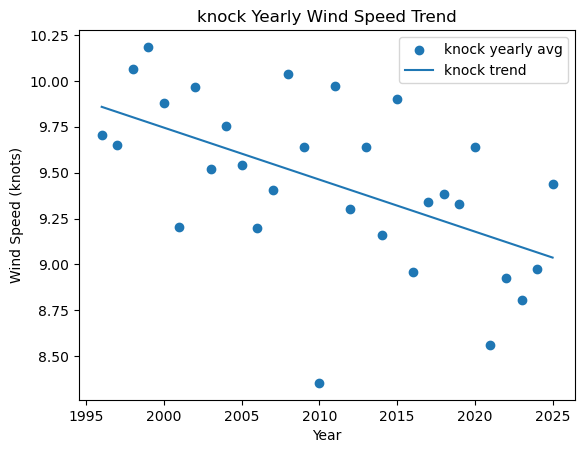

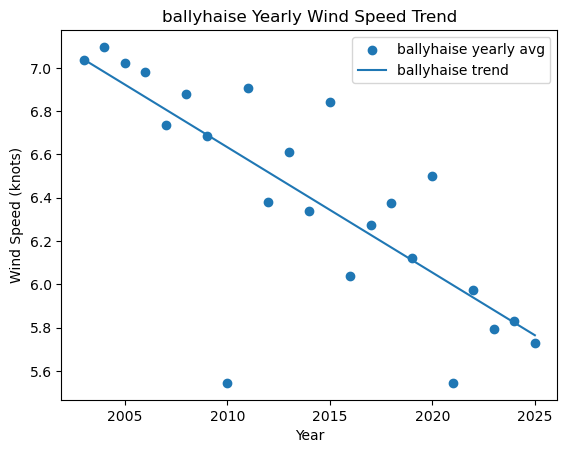

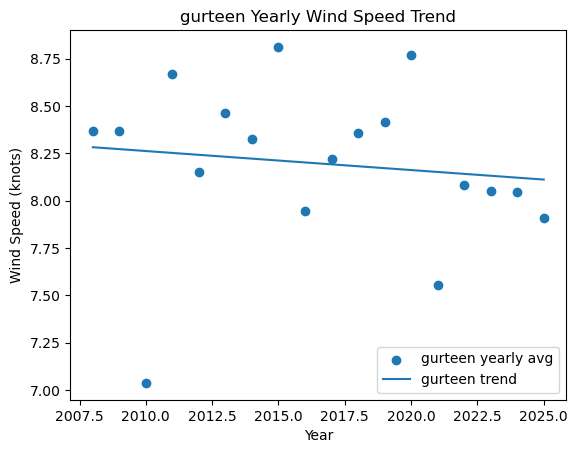

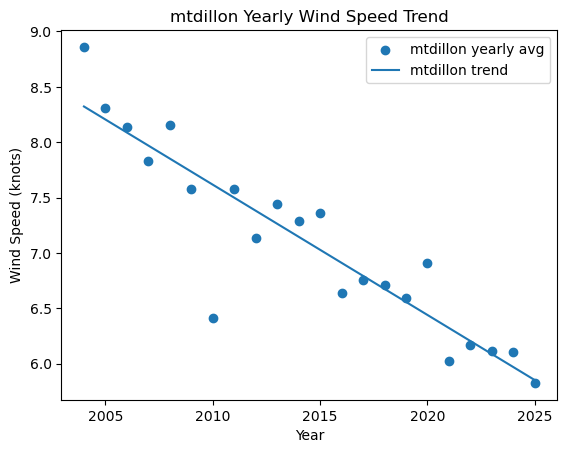

In [506]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    yearly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.year)["wdsp"].mean()
    
    x = yearly_mean.index.values
    y = yearly_mean.values
    
    coeffs = np.polyfit(x, y, 1)
    trend = coeffs[0] 
    #print(f"{station}: trend = {trend:.3f} knots/year") 

    y_fit = np.polyval(coeffs, x) 
    plt.scatter(x, y, label=f"{station} yearly avg")
    plt.plot(x,y_fit, label=f"{station} trend")
    plt.title(f"{station} Yearly Wind Speed Trend")
    plt.xlabel("Year")
    plt.ylabel("Wind Speed (knots)")
    plt.legend()
    plt.show()

##### Reference: 
https://medium.com/@amit25173/understanding-numpy-polyfit-with-step-by-step-examples-78247c0a9eed

### Heavy rain analysis

In [507]:
# Variable to store rain data
rain_percentage = []

# Loop through all stations data
for key in all_stations:
    table_name = f"{key}_data"

# Calculating percentage of heavy rain
# Count when rain => 20
    query2 = f""" 
    SELECT 
        COUNT(CASE WHEN rain >= 20 THEN 1 END) * 100.0 / COUNT(*) AS heavy_rain_perc
    FROM {table_name}"""
    
    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result2 = pd.read_sql(query2, conn).round(1)
    result2["Station"] = key # Adding a new column with station names
    rain_percentage.append(result2) # Appending each result to variable rain_percentage

# Concating data from all stations to one dataframe
rain_df = pd.concat(rain_percentage, ignore_index=True)
print(rain_df)    

   heavy_rain_perc     Station
0              1.3        mace
1              1.2       malin
2              1.8       knock
3              1.3  ballyhaise
4              1.1     gurteen
5              1.3    mtdillon


##### References:
Heavy rain threshhold: https://www.sciencedirect.com/science/article/pii/S0960148119319159, topic 2.1

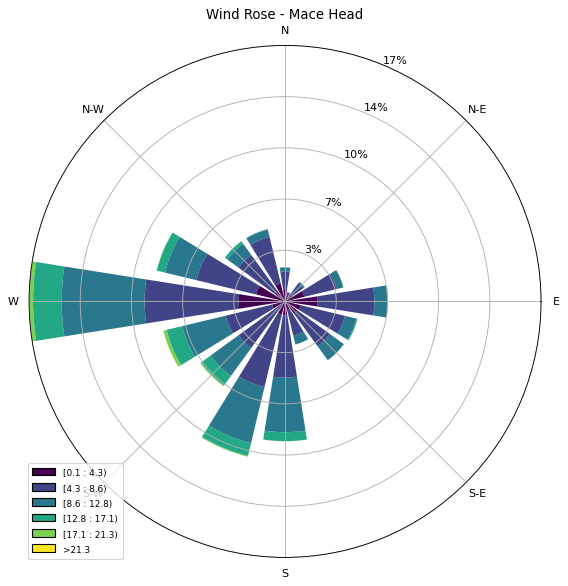

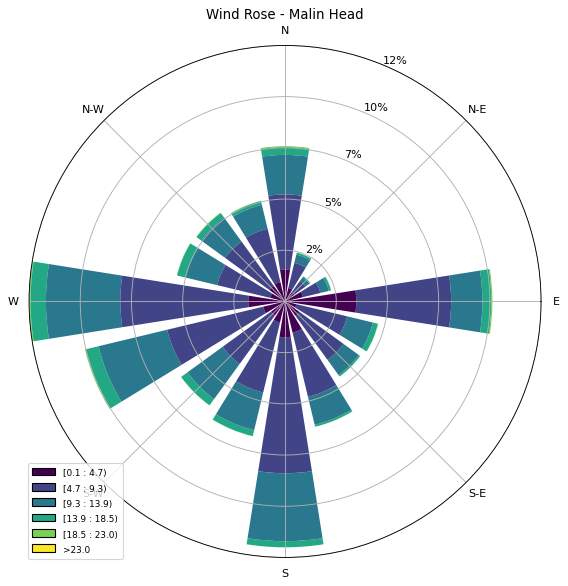

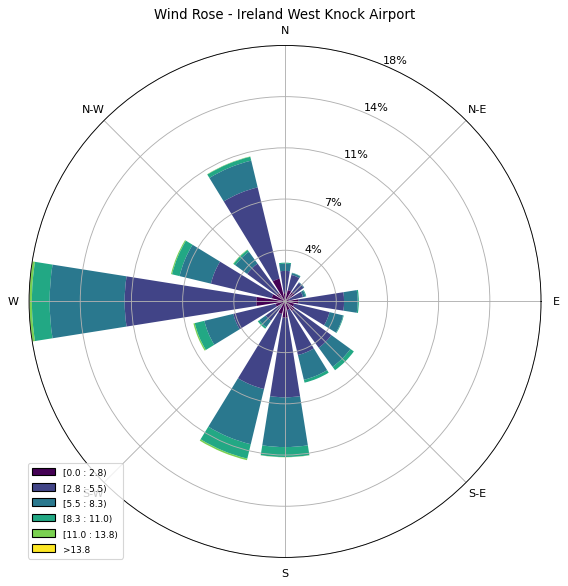

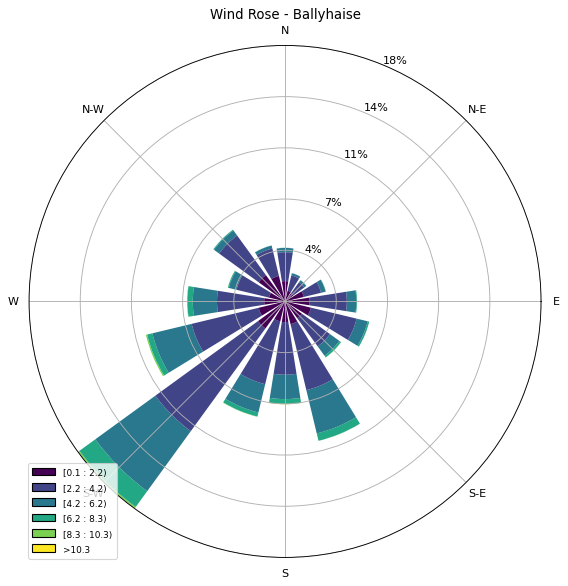

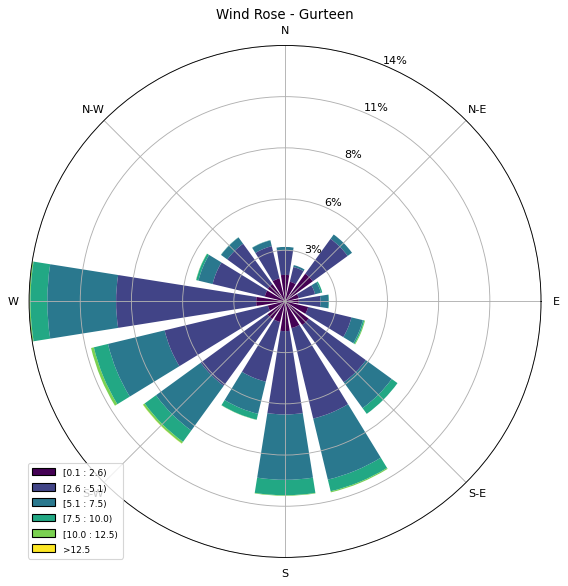

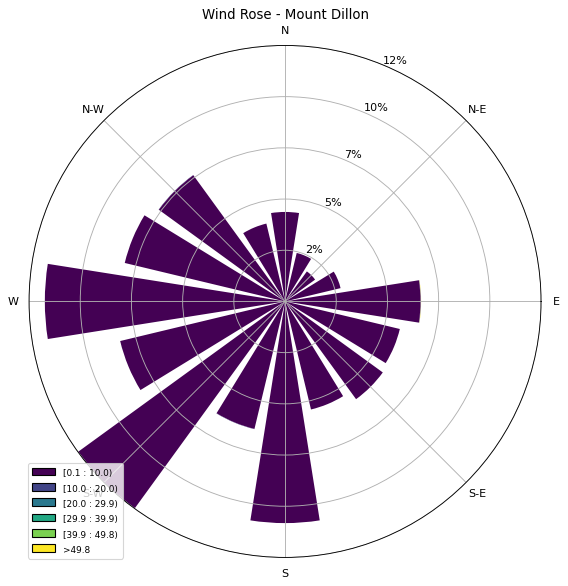

In [ ]:
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    ax = WindroseAxes.from_ax()
    ax.bar(df_weather[station]["ddhm"], df_weather[station]["ms_wdsp"], normed=True, opening=0.85)
    ax.set_legend()
    fmt = '%.0f%%' 
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    plt.title(f"Wind Rose - {label}")
    plt.show()

#df_2008 = df_weather[station][df_weather[station]["date"].dt.year >= 2008]

##### References
Plot wind roses: https://medium.com/@benjamin.ganko/wind-roses-in-python-pretty-straight-forward-sort-of-d859e64c5fba